# Figures with Dynamics

This notebook is intended to provide figures relating to the *dynamics* of the models we are discussing. Figures related to *inference* are handled in separate notebooks for each data set. 

In [60]:
import numpy as np
from numba import jit

from py.model import *
from py.scores import *
from py.utils import *

# from SpringRank import SpringRank

from matplotlib import pyplot as plt

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial Unicode MS"

# Setup: 

In [3]:
cset = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377']
cset_muted = ['#CC6677', '#332288', '#DDCC77', '#117733', '#88CCEE', '#882255', '#44AA99', '#999933', '#AA4499', '#DDDDDD','#000000']

In [121]:
@jit(nopython=True)
def linear_feature(s):
    return(np.outer(np.ones(len(s)), s))



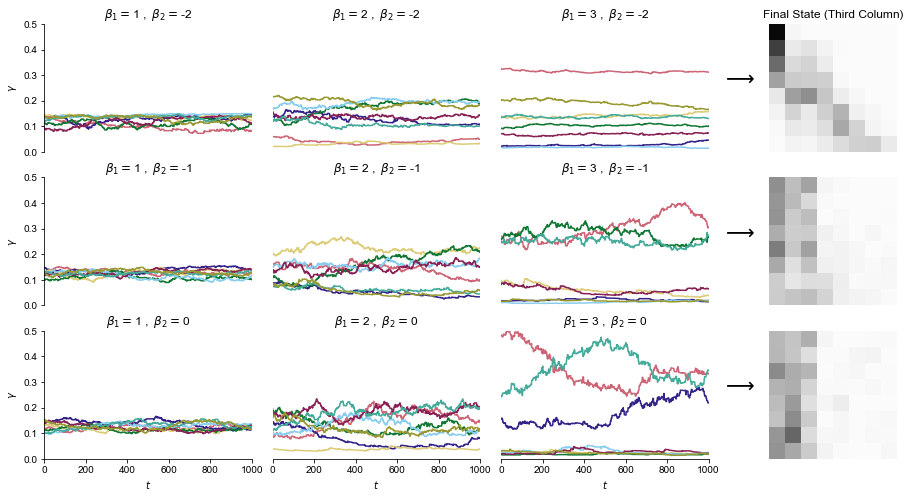

In [128]:
np.random.seed(seed=6)

BETA_1 = np.array([1,2,3])
BETA_2 = np.array([-2, -1, 0])

highlight_col = 2

def quadratic_feature(s):
    S = linear_feature(s)
    V = (S - S.T)**2
    return(V)

lam = .995
n_rounds = 2000
m_updates = 1

n = 8
A0 = np.random.rand(n,n)
A0 = A0/A0.sum()

ymax = 0.5
ymin = 0.0

fig, axarr = plt.subplots(3,4, figsize = (16, 8))

for i in range(3):
    for j in range(3):
        ax = axarr[j,i]
        beta_1 = BETA_1[i]
        beta_2 = BETA_2[j]

        M = model()
        M.set_score(score_function = lambda A: homebrew_SpringRank_score(A.T))
        M.set_features([linear_feature, 
                        quadratic_feature])

        M.simulate(beta = np.array([beta_1, beta_2]), 
                   lam = lam, 
                   A0 = A0, 
                   n_rounds = n_rounds, 
                   update = stochastic_update, 
                   m_updates = m_updates)
        GAMMA = M.get_rates()
        
        for k in range(n):
            p = ax.plot(GAMMA.mean(axis = 1)[np.int(n_rounds/2):,k], color = cset_muted[k])
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        ax.set(ylim = (ymin, ymax))
        ax.set(xlim = (0, np.int(n_rounds/2)))
        
        if j < 2:
            ax.spines['bottom'].set_visible(False)
            ax.xaxis.set_ticks([])
            plt.xticks([])

        if i > 0:
            ax.spines['left'].set_visible(False)
            ax.yaxis.set_ticks([])
            plt.yticks([])

        if j == 2:
            ax.set(xlabel = r'$t$')
        if i == 0:
            ax.set(ylabel = r'$\gamma$')
        
        ax.set_title(
            r'$\beta_1 = $' + str(round(beta_1,2)) + r'$\;$,$\;$ $\beta_2 = $' + str(round(beta_2,2))
        )
        
        if i == highlight_col:
            ax = axarr[j,3]
            A = M.get_states()[-1]

            v = GAMMA[-1].mean(axis = 0) 
            ax.imshow(np.ones_like(A), cmap = 'Greys', vmax = 1, vmin = 0, alpha = 1)
            ax.imshow(matrix_sort(A, -v), vmax = .1,  cmap = 'Greys', alpha = .99)
#             axarr[j,3].axis('off')
            ax.set_ylabel(r'$\longrightarrow$', rotation=0, fontsize=20, labelpad=30, color = 'black')
            for pos in ['bottom', 'top', 'left', 'right']:
                ax.spines[pos].set_visible(False)
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])

axarr[0,3].set_title('Final State (Third Column)')

plt.subplots_adjust(wspace = 0.1)

plt.savefig('fig/dynamics_examples.png', bbox_inches = 'tight', dpi = 300)

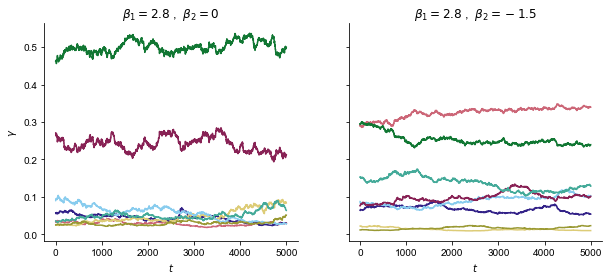

In [73]:
def quadratic_feature(s):
    S = linear_feature(s)
    V = (S - S.T)**2
    return(V)

lam = .998
n_rounds = 10000
m_updates = 1

n = 8
A0 = np.random.rand(n,n)
A0 = A0/A0.sum()


fig, axarr = plt.subplots(1,2, figsize = (10, 4), sharey = True)

M = model()
M.set_score(score_function = lambda A: homebrew_SpringRank_score(A.T))
M.set_features([linear_feature, 
                quadratic_feature])

M.simulate(beta = np.array([2.8, 0]), 
           lam = lam, 
           A0 = A0, 
           n_rounds = n_rounds, 
           update = stochastic_update, 
           m_updates = m_updates)
GAMMA = M.get_rates()

for j in range(n):
    p = axarr[0].plot(GAMMA.mean(axis = 1)[5000:,j], color = cset_muted[j])

M.simulate(beta = np.array([2.8, -1.5]), 
           lam = lam, 
           A0 = A0, 
           n_rounds = n_rounds, 
           update = stochastic_update, 
           m_updates = m_updates)
GAMMA = M.get_rates()
for j in range(n):
    p = axarr[1].plot(GAMMA.mean(axis = 1)[5000:,j], color = cset_muted[j])


for ax in axarr:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set(xlabel = r'$t$')
    
axarr[0].set(ylabel = r'$\gamma$')
axarr[0].set_title(r'$\beta_1 = 2.8\;$, $\;\beta_2 = 0$')
axarr[1].set_title(r'$\beta_1 = 2.8\;$, $\;\beta_2 = -1.5$')

plt.savefig('fig/SR_linear_and_quadratic.png', bbox_inches = 'tight', dpi = 300)